In [16]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import RobustScaler
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class PETNN(nn.Module):
    def __init__(self, input_size, hidden_size, cell_dim=5, T_init=1.0, hard_switch=True, Rt_bias = 1.5 , Zt_bias = 1.0, dropout =0.2 ,  forecast_horizon=24):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.cell_dim = cell_dim if cell_dim is not None else hidden_size

        self.forecast_horizon = forecast_horizon
        self.Rt_bias = Rt_bias
        self.Zt_bias = Zt_bias
        self.dropout = dropout

        self.T_init = T_init

        self.hard_switch = hard_switch

        self.WIt = nn.Linear(input_size, self.cell_dim)
        self.WZt = nn.Linear(input_size + hidden_size, self.cell_dim)
        self.WRt = nn.Linear(input_size, self.cell_dim)
        self.WZc = nn.Linear(input_size + hidden_size, self.cell_dim)
        self.WZw = nn.Linear(input_size + hidden_size, hidden_size)

        self.Wh = nn.Linear(input_size + hidden_size + self.cell_dim, hidden_size)

        self.ln_hidden = nn.LayerNorm(hidden_size)

        self.prediction_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 3),
            nn.LayerNorm(hidden_size * 3),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 3, forecast_horizon))


        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
                    if module == self.WRt:
                        nn.init.constant_(module.bias, self.Rt_bias)
                    elif module == self.WZt:
                        nn.init.constant_(module.bias, self.Zt_bias)

    def forward(self, x):

        batch_size, seq_len, _ = x.shape
        device = x.device

        S_prev = torch.zeros(batch_size, self.hidden_size, device=device)
        T_prev = torch.full((batch_size, self.cell_dim), self.T_init, device=device)
        C_prev = torch.zeros(batch_size, self.cell_dim, device=device)

        total_resets = 0

        for t in range(seq_len):
            X_t = x[:, t, :]
            S_prev, C_prev, T_prev, num_resets = self.update_step(X_t, S_prev, C_prev, T_prev)
            total_resets += num_resets

        predictions = self.prediction_head(S_prev)

        return predictions, total_resets

    def update_step(self, X_t, S_prev, C_prev, T_prev ):

        It = self.WIt(X_t)
        Rt = F.softplus(self.WRt(X_t))

        concat_input = torch.cat([X_t, S_prev], dim=-1)

        Zt = self.WZt(concat_input)
        Zc = self.WZc(concat_input)
        Zw = self.WZw(concat_input)

        T_new = Rt * torch.sigmoid((T_prev + Zt)) - 1

        num_resets = 0

        if self.hard_switch:
            m = (T_new < 0).float()
            num_resets = (T_new < 0).sum().item()
            T_new = T_new.clamp(min=0)

        else:
            m = torch.sigmoid(T_new)

        C_new = (1 - m) * C_prev + m * It + Zc
        C_modulated = (1 - m) * C_prev

        h_input = torch.cat([X_t, S_prev, C_modulated], dim=-1)

        h_input = self.Wh(h_input)

        h_state = torch.sigmoid(h_input)

        state_update = (1 - Zw) * S_prev + Zw * h_state
        S_new = torch.sigmoid(state_update)

        return S_new, C_new, T_new, num_resets

def plot_timeseries(df, features, time_col='date'):
    fig, axes = plt.subplots(4, 2, figsize=(15, 16))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        axes[i].plot(df[time_col], df[feature], linewidth=0.8, alpha=0.8)
        axes[i].set_title(f'{feature} over time', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(feature)
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)

        mean_val = df[feature].mean()
        axes[i].axhline(y=mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
        axes[i].legend()

    if len(features) < len(axes):
        for j in range(len(features), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def compute_zscore(column):

    mean = np.mean(column)
    std_dev = np.std(column)
    zscore_column = (column - mean) / std_dev
    return zscore_column

def create_sequences(data, seq_length, pred_length, target_col_name):
    X, y = [], []

    target_index = data.columns.get_loc(target_col_name)
    data_array = data.values.astype(np.float32)

    for i in range(len(data_array) - seq_length - pred_length + 1):
        X.append(data_array[i:i+seq_length])
        y.append(data_array[i+seq_length:i+seq_length+pred_length, target_index])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    if y.ndim == 1:
        y = y.reshape(-1, 1)

    return X, y, target_index


def create_loaders(data, seq_length, pred_length, batch_size=32, target_col_name='target'):

    total_len = len(data)
    train_size = int(0.7 * total_len)
    val_size = int(0.15 * total_len)

    target_col_index = data.columns.get_loc(target_col_name)

    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:train_size + val_size]
    val_data = data.iloc[train_size + val_size:]


    scaler = RobustScaler()
    scaler.fit(train_data)

    train_scaled = pd.DataFrame(scaler.transform(train_data),columns=data.columns,index=train_data.index)
    val_scaled = pd.DataFrame(scaler.transform(val_data),columns=data.columns,index=val_data.index)
    test_scaled = pd.DataFrame(scaler.transform(test_data),columns=data.columns,index=test_data.index)

    X_train, y_train, _ = create_sequences(train_scaled, seq_length, pred_length, target_col_name)
    X_val, y_val, _ = create_sequences(val_scaled, seq_length, pred_length, target_col_name)
    X_test, y_test, _ = create_sequences(test_scaled, seq_length, pred_length, target_col_name)

    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

    return train_loader, val_loader, test_loader, scaler, target_col_index

def one_epoch(model, train_loader, val_loader, optimizer, criterion, device):

    model.train()
    train_loss = 0
    total_releases = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, releases = model(data)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

        if isinstance(releases, torch.Tensor):
             total_releases += releases.item()
        else:
             total_releases += releases
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_releases = total_releases / len(train_loader)

    return avg_train_loss, avg_val_loss, avg_releases

def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs, _ = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(test_loader)

def evaluate_model(model, data_loader, target_scaler, device):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs, _ = model(X_batch)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(y_batch.numpy())
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    pred_shape = predictions.shape
    predictions_flat = predictions.reshape(-1, 1)
    targets_flat = targets.reshape(-1, 1)

    predictions_original = target_scaler.inverse_transform(predictions_flat)
    targets_original = target_scaler.inverse_transform(targets_flat)

    predictions_original = predictions_original.reshape(pred_shape)
    targets_original = targets_original.reshape(pred_shape)

    mse = mean_squared_error(targets_original, predictions_original)
    mae = mean_absolute_error(targets_original, predictions_original)

    rmse = np.sqrt(mse)
    print(f"MSE={mse}")
    print(f"MAE={mae}")
    print(f"RMSE={rmse}")


    return {'predictions': predictions_original,'targets': targets_original}


def plot_residuals_distribution(result):

  n = len(result["predictions"])
  residuals = []
  for i in range(n):
      residual = result["targets"][i] - result["predictions"][i]
      residuals.append(residual)

  residuals_original = np.array(residuals)

  residuals_rounded = np.round(residuals_original).astype(int)

  plt.figure(figsize=(14, 6))
  plt.hist(residuals_rounded.flatten(), bins=50, edgecolor='black', alpha=0.7)

  plt.title("Distribution of Residuals")
  plt.xlabel("Residual")
  plt.ylabel("Frequency")
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

  return residuals_original

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv")

df['date'] = pd.to_datetime(df['date'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']])
scaled_df = pd.DataFrame(scaled_data, columns=['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'])

for feature in ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']:
    print(f"{feature}: [{df[feature].min():.2f}, {df[feature].max():.2f}]")

scaled_df['day_of_week'] = df['date'].dt.dayofweek
scaled_df['month'] = df['date'].dt.month

day_onehot = pd.get_dummies(scaled_df['day_of_week'], prefix='day', dtype=np.float32)
month_onehot = pd.get_dummies(scaled_df['month'], prefix='month', dtype=np.float32)

final_data = pd.concat([scaled_df[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']],day_onehot, month_onehot], axis=1)
final_data = final_data.astype(np.float32)

HUFL: [0.00, 107.89]
HULL: [-29.32, 36.44]
MUFL: [10.43, 93.23]
MULL: [-6.65, 29.81]
LUFL: [-14.62, 17.22]
LULL: [-31.46, 3.73]
OT: [-2.65, 58.88]


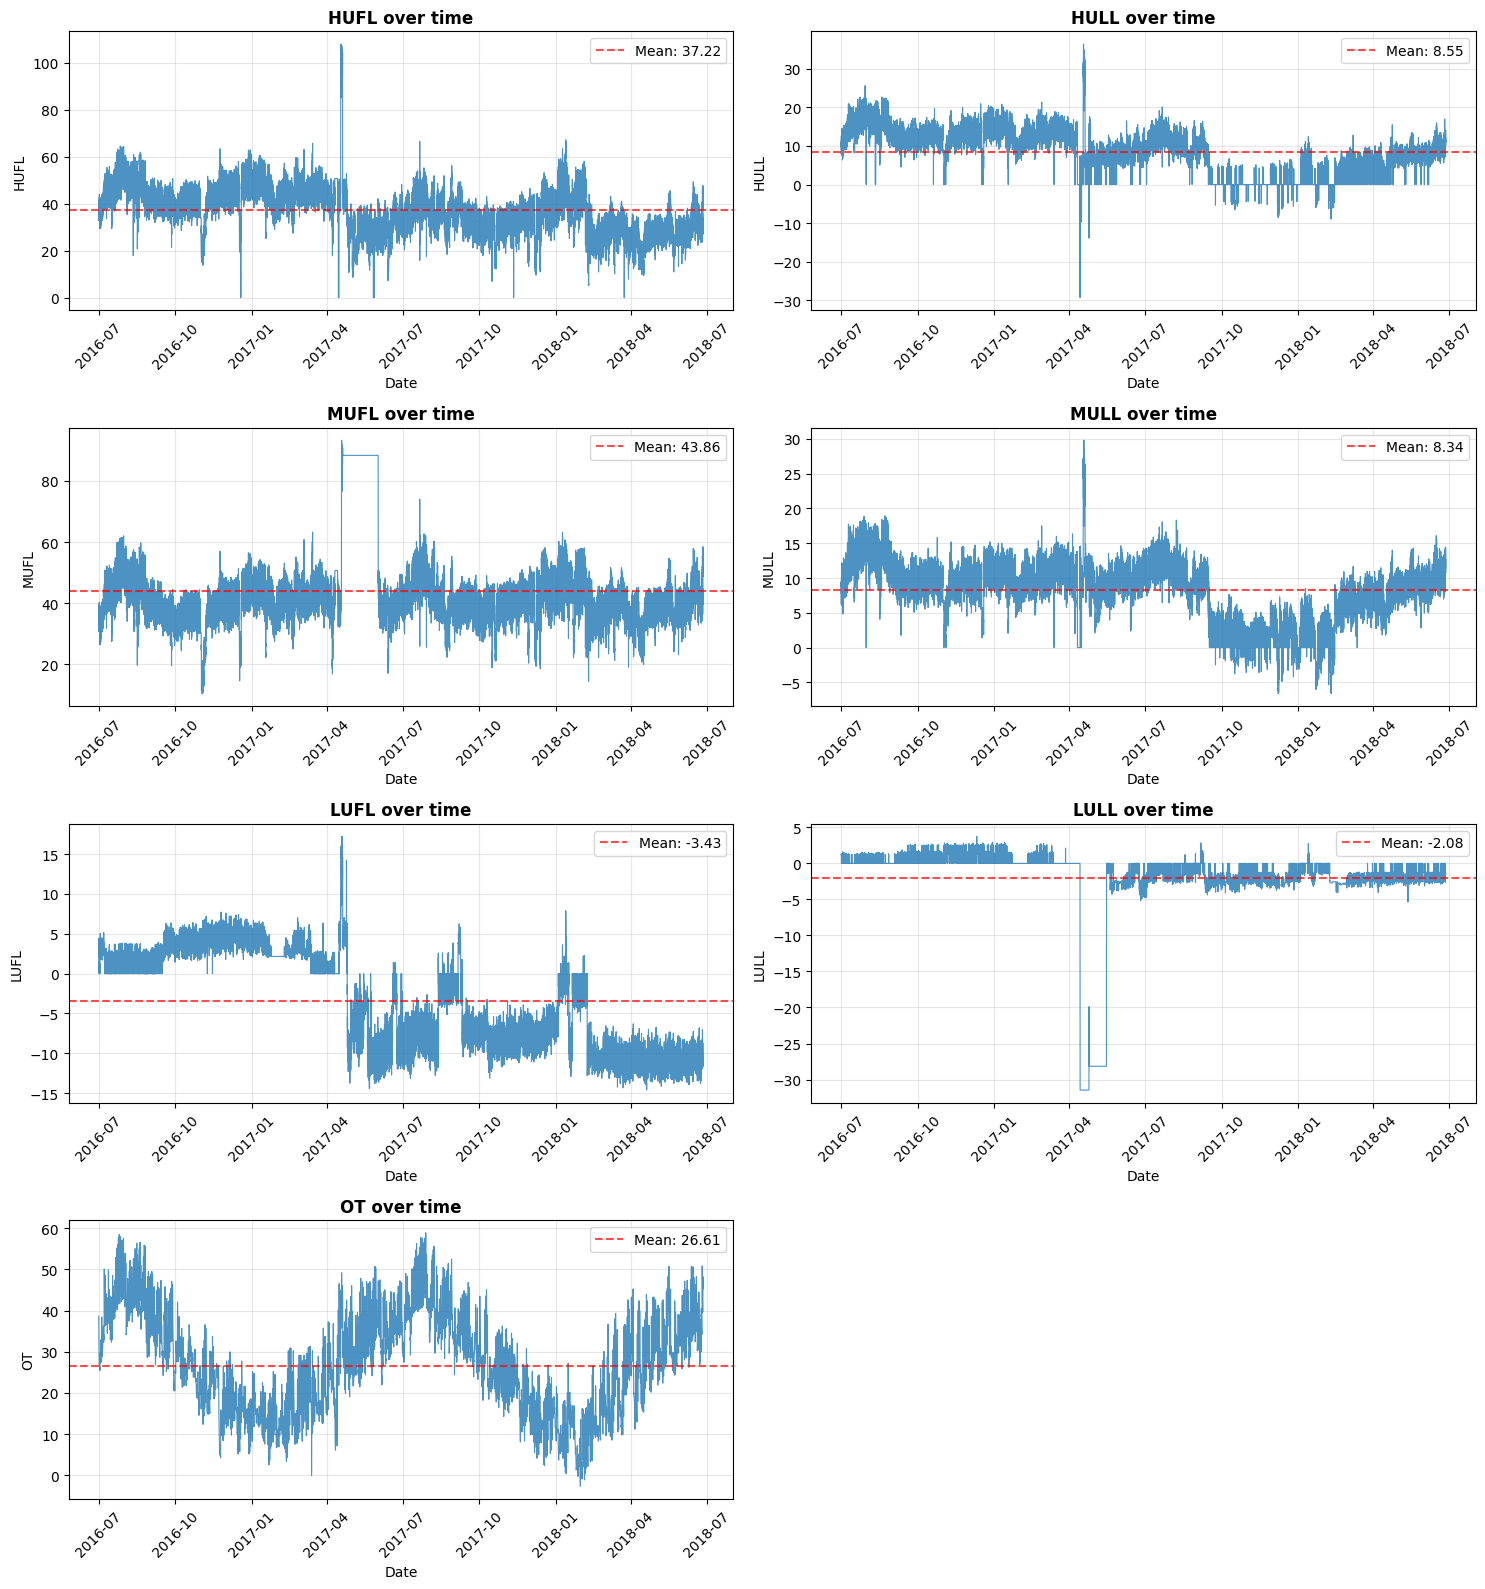

In [5]:
features = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
plot_timeseries(df, features)


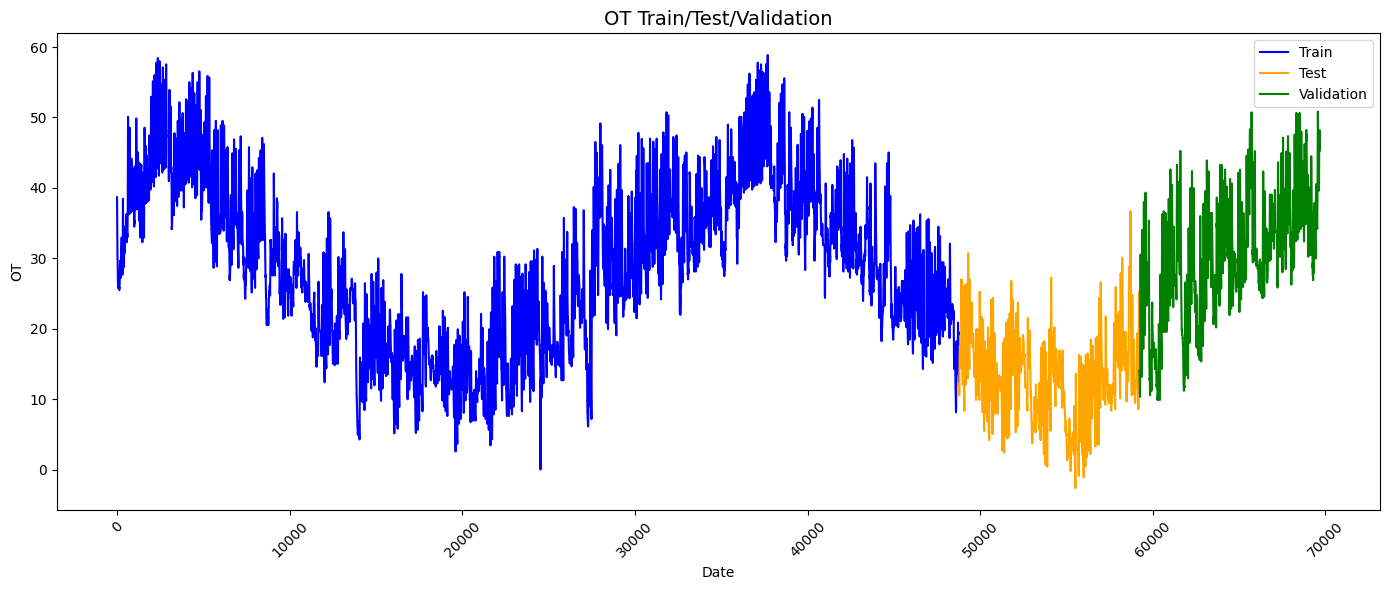

In [25]:
import seaborn as sns

total_len = len(df)
train_size = int(0.7 * total_len)
val_size = int(0.15 * total_len)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:train_size + val_size]
val_data = df.iloc[train_size + val_size:]

plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data["OT"], label='Train', color='blue', linewidth=1.5)
plt.plot(test_data.index, test_data["OT"], label='Test', color='orange', linewidth=1.5)
plt.plot(val_data.index, val_data["OT"], label='Validation', color='green', linewidth=1.5)
plt.title("OT Train/Test/Validation", fontsize=14)
plt.xlabel("Date")
plt.ylabel("OT")
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
df_no_date = df.drop(columns=["date"])
features = [col for col in df_no_date.columns if col != 'OT']

feature_scaler = RobustScaler()
scaled_features = feature_scaler.fit_transform(df_no_date[features])

target_scaler = RobustScaler()
scaled_target = target_scaler.fit_transform(df_no_date[['OT']])

scaled_df = pd.DataFrame(np.concatenate([scaled_features, scaled_target], axis=1),columns=features + ['OT'],index=df.index)

scaled_df['date'] = df['date']

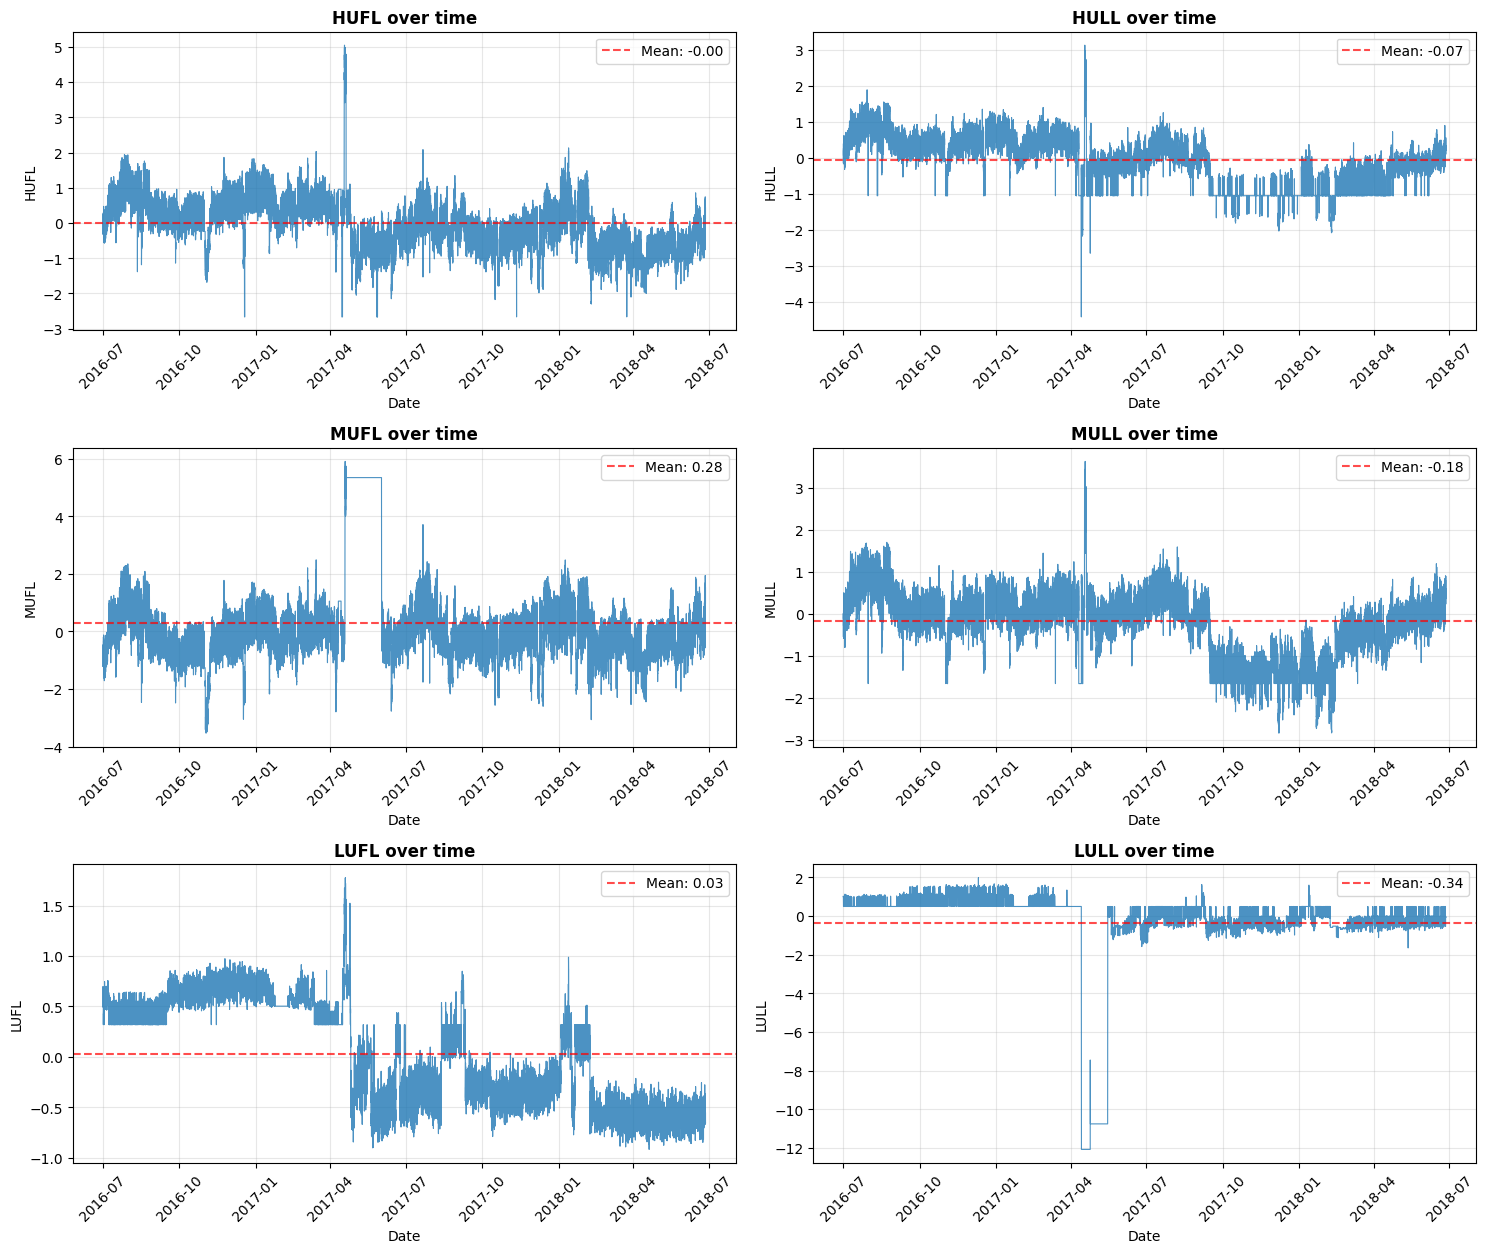

In [ ]:
plot_timeseries(scaled_df, features)

In [7]:
seq_length = 96
pred_length = 96
batch_size = 32

train_loader, val_loader, test_loader, scaler, target_idx = create_loaders(final_data, seq_length=seq_length, pred_length=pred_length, batch_size=batch_size, target_col_name='OT')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_batch = next(iter(train_loader))
input_size = sample_batch[0].shape[-1]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from itertools import product

param_grid = {'switch': [True],'weight_decay': [0.0005],'bias_R': [4.75 , 4.5 ,4],'cell_dim': [32 , 48 , 64],'lr': [0.001] , "dropout" : [0.2]}

combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results = []

MIN_RELEASES = 0
MAX_RELEASES = 7000
idx = 0

for combo in combinations:

    params = dict(zip(param_names, combo))
    seed = 42 + idx
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seed {seed}")
    print(f"\nTesting: Wd={params['weight_decay']}, Cell={params['cell_dim']}, "
          f"Switch={params['switch']}, Bias_R={params['bias_R']}, Lr={params['lr']}, Dropout={params['dropout']}")


    model = PETNN(input_size=input_size,hidden_size=64,cell_dim=params['cell_dim'],hard_switch=params['switch'],Rt_bias=params['bias_R'],dropout=params["dropout"], forecast_horizon=pred_length).to(device)

    criterion =nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.Adam(model.parameters(),lr=params['lr'],weight_decay=params['weight_decay'])
    skipped = False
    num_epochs = 3
    for epoch_num in range(num_epochs):
        train_loss, val_loss, avg_releases = one_epoch(model, train_loader, val_loader, optimizer, criterion, device)

        if params['switch']:
            print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")
        if avg_releases < MIN_RELEASES or avg_releases > MAX_RELEASES:
            print(f"  -> Skipping. Avg Releases ({avg_releases:.2f}) not in [{MIN_RELEASES}, {MAX_RELEASES}].")
            skipped = True
            break

    if not skipped:
        gap = train_loss - val_loss
        loss_final = val_loss + gap
        results.append({**params,'final_train_loss': train_loss,'final_val_loss': val_loss,'loss': loss_final})
    else:
        results.append({**params, 'loss': float('inf')})
    idx += 1
best_result = min(results, key=lambda x: x['loss'])

Seed 42

Testing: Wd=0.0005, Cell=32, Switch=True, Bias_R=4.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.045196, Val=0.046234, Avg Releases=1973.74
Epoch 2: Train=0.031290, Val=0.045556, Avg Releases=1978.96
Epoch 3: Train=0.027637, Val=0.034864, Avg Releases=1974.72
Seed 43

Testing: Wd=0.0005, Cell=48, Switch=True, Bias_R=4.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.044878, Val=0.044351, Avg Releases=1904.12
Epoch 2: Train=0.032770, Val=0.049854, Avg Releases=1927.76
Epoch 3: Train=0.031423, Val=0.043894, Avg Releases=1870.57
Seed 44

Testing: Wd=0.0005, Cell=64, Switch=True, Bias_R=4.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.046110, Val=0.045777, Avg Releases=2017.77
Epoch 2: Train=0.034223, Val=0.043147, Avg Releases=2044.14
Epoch 3: Train=0.032072, Val=0.041339, Avg Releases=2024.51
Seed 45

Testing: Wd=0.0005, Cell=32, Switch=True, Bias_R=4.5, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.044753, Val=0.046389, Avg Releases=2488.35
Epoch 2: Train=0.032042, Val=0.046790, Avg Releases=2472.

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model_1 = PETNN(input_size=input_size,hidden_size=64,cell_dim=32,hard_switch=True,Rt_bias=4.75 ,dropout= 0.2, forecast_horizon=pred_length).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
patience = 3
patience_counter = 0

for epoch_num in range(15):
    train_loss, val_loss, avg_releases = one_epoch(model_1, train_loader, val_loader, optimizer, criterion, device)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch_num + 1
        best_model_state = {'epoch': epoch_num + 1,'model_state_dict': model_1.state_dict(),'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,'val_loss': val_loss,'avg_releases': avg_releases}
        torch.save(best_model_state, 'best_model.pth')
        patience_counter = 0
        print(f"New best!")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{patience})")

    print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch_num+1} epochs")
        break

print(f"\n=== Best model ===")
print(f"Epoch: {best_epoch}")
print(f"Train Loss: {best_model_state['train_loss']:.6f}")
print(f"Val Loss: {best_model_state['val_loss']:.6f}")

New best!
Epoch 1: Train=0.218783, Val=0.224100, Avg Releases=2009.88
No improvement (1/3)
Epoch 2: Train=0.186258, Val=0.233356, Avg Releases=2032.21
New best!
Epoch 3: Train=0.180007, Val=0.214162, Avg Releases=2070.96
New best!
Epoch 4: Train=0.170097, Val=0.209242, Avg Releases=2053.57
New best!
Epoch 5: Train=0.153050, Val=0.188394, Avg Releases=2079.41
No improvement (1/3)
Epoch 6: Train=0.143699, Val=0.192308, Avg Releases=2054.76
No improvement (2/3)
Epoch 7: Train=0.137380, Val=0.191142, Avg Releases=2046.70
No improvement (3/3)
Epoch 8: Train=0.132793, Val=0.195739, Avg Releases=2060.20

Early stopping triggered after 8 epochs

=== Best model ===
Epoch: 5
Train Loss: 0.153050
Val Loss: 0.188394


In [11]:
model_1.eval()
result= evaluate_model(model_1, test_loader, target_scaler, device)

MSE=25.18821144104004
MAE=3.979093551635742
RMSE=5.018785853275674


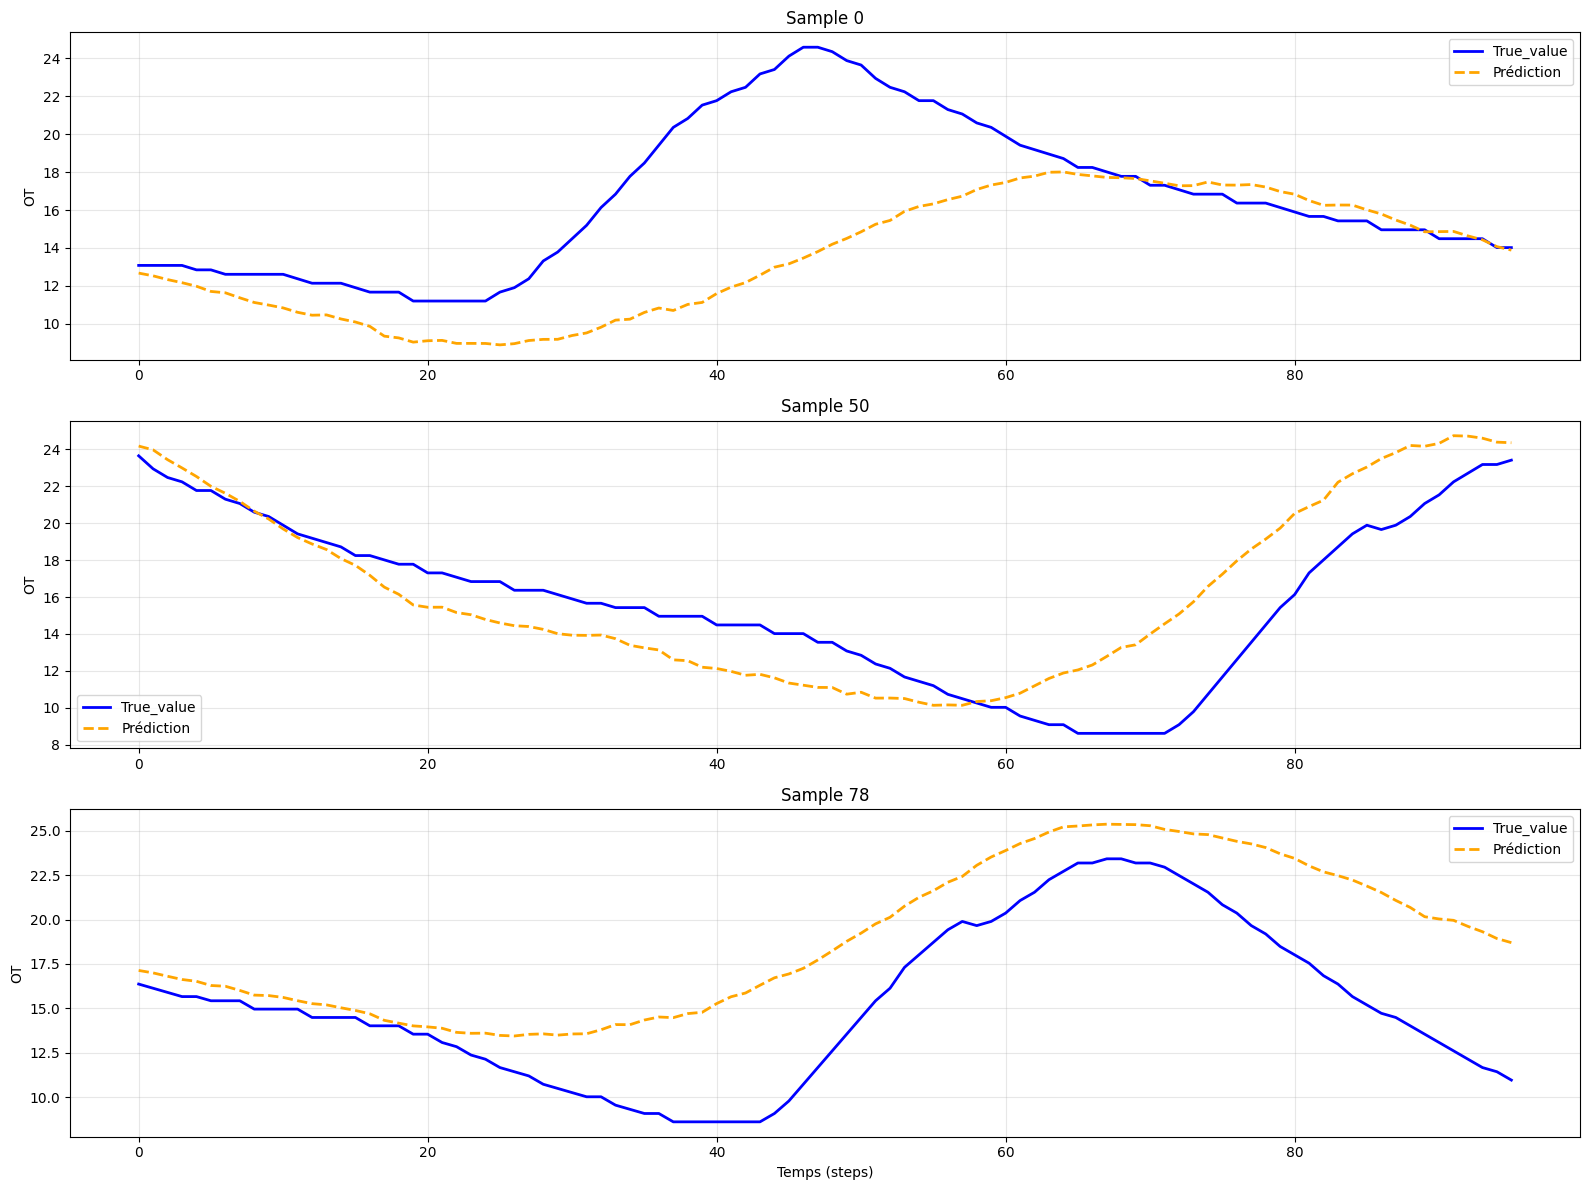

In [35]:
indices_to_plot = [0 , 50 , 78]

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for i, idx in enumerate(indices_to_plot):
    if idx >= len(result["targets"]):
        print(f"Warning: index {idx} out of range")
        continue

    sample_y = result["targets"][idx].flatten()
    sample_y_pred = result["predictions"][idx].flatten()

    axes[i].plot(range(len(sample_y)), sample_y, label='True_value', color='blue', linewidth=2)
    axes[i].plot(range(len(sample_y_pred)), sample_y_pred, label='Prediction', color='orange', linewidth=2, linestyle='--')
    axes[i].set_title(f"Sample {idx}", fontsize=12)
    axes[i].set_ylabel("OT")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

axes[2].set_xlabel("Steps")
plt.tight_layout()
plt.show()

/tmp/ipython-input-1610383468.py:314: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


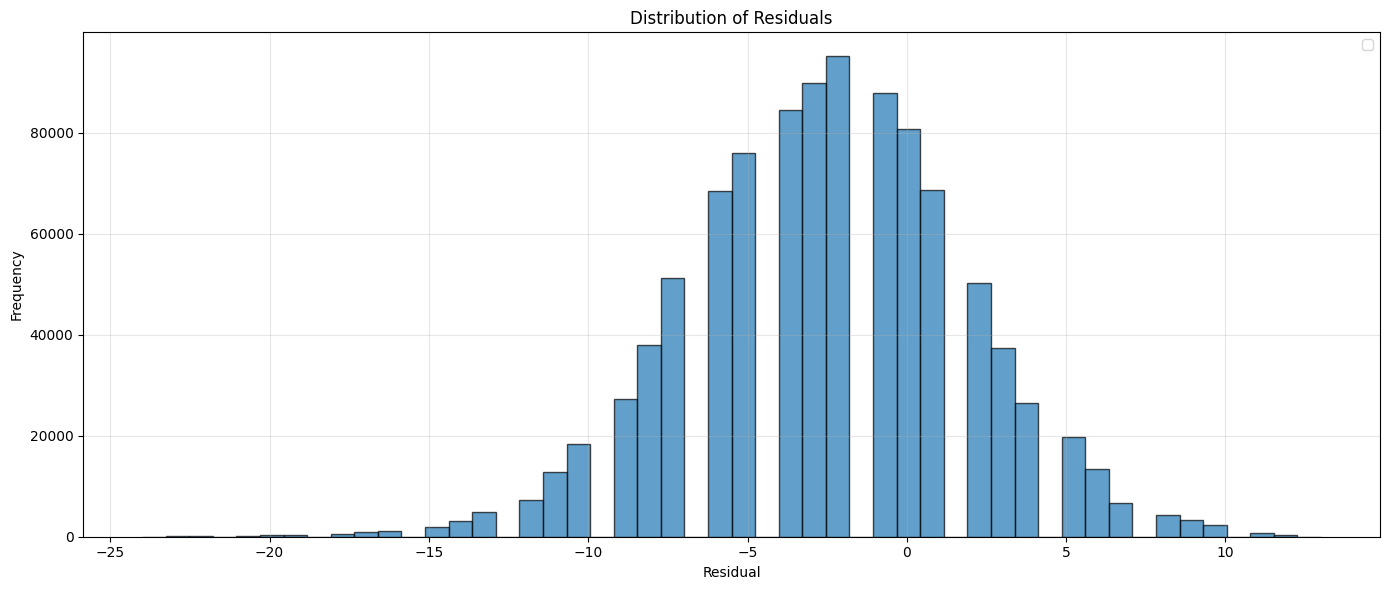

In [17]:
residuals = plot_residuals_distribution(result)

In [21]:
print(f"Mean of residuals: {residuals.mean()}")

Mean of residuals: -2.524387836456299


## Result

The model shows promising results: the distribution of the residuals looks like a normal distribution, which validates the ARIMA hypothesis. However, the distribution is not fully centered around 0 but more around -2.35. This is good information, indicating that the model slightly over estimates the values, and on the plot, we can see this tendency toward negative values

In [9]:
from itertools import product

param_grid = {'switch': [False],'weight_decay': [0.0005],'bias_R': [4.75 , 4.5 ,4],'cell_dim': [32 , 48 , 64],'lr': [0.001] , "dropout" : [0.2]}

combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results = []

MIN_RELEASES = 0
MAX_RELEASES = 7000
idx = 0

for combo in combinations:

    params = dict(zip(param_names, combo))
    seed = 42 + idx
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seed {seed}")
    print(f"\nTesting: Wd={params['weight_decay']}, Cell={params['cell_dim']}, "
          f"Switch={params['switch']}, Bias_R={params['bias_R']}, Lr={params['lr']}, Dropout={params['dropout']}")


    model = PETNN(input_size=input_size,hidden_size=64,cell_dim=params['cell_dim'],hard_switch=params['switch'],Rt_bias=params['bias_R'],dropout=params["dropout"], forecast_horizon=pred_length).to(device)

    criterion =nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.Adam(model.parameters(),lr=params['lr'],weight_decay=params['weight_decay'])

    skipped = False
    num_epochs = 3
    for epoch_num in range(num_epochs):
        train_loss, val_loss, avg_releases = one_epoch(model, train_loader, val_loader, optimizer, criterion, device)
        print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")

    if not skipped:
        gap = train_loss - val_loss
        loss_final = val_loss + gap
        results.append({**params,'final_train_loss': train_loss,'final_val_loss': val_loss,'loss': loss_final})
    else:
        results.append({**params, 'loss': float('inf')})
    idx += 1
best_result = min(results, key=lambda x: x['loss'])

Seed 42

Testing: Wd=0.0005, Cell=32, Switch=False, Bias_R=4.75, Lr=0.001, Dropout=0.2


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: Train=0.051777, Val=0.055031, Avg Releases=0.00
Epoch 2: Train=0.038846, Val=0.054876, Avg Releases=0.00
Epoch 3: Train=0.038729, Val=0.052356, Avg Releases=0.00
Seed 43

Testing: Wd=0.0005, Cell=48, Switch=False, Bias_R=4.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.050916, Val=0.052270, Avg Releases=0.00
Epoch 2: Train=0.038527, Val=0.056753, Avg Releases=0.00
Epoch 3: Train=0.038521, Val=0.053237, Avg Releases=0.00
Seed 44

Testing: Wd=0.0005, Cell=64, Switch=False, Bias_R=4.75, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.051795, Val=0.055215, Avg Releases=0.00
Epoch 2: Train=0.038392, Val=0.059756, Avg Releases=0.00
Epoch 3: Train=0.038392, Val=0.066685, Avg Releases=0.00
Seed 45

Testing: Wd=0.0005, Cell=32, Switch=False, Bias_R=4.5, Lr=0.001, Dropout=0.2
Epoch 1: Train=0.050388, Val=0.050875, Avg Releases=0.00
Epoch 2: Train=0.038622, Val=0.052833, Avg Releases=0.00
Epoch 3: Train=0.038534, Val=0.053662, Avg Releases=0.00
Seed 46

Testing: Wd=0.0005, Cell=48, Switch=False, Bias

## Hard Switch vs Smooth Switch

The model performed significantly better before, when using the hard switch. This suggests that following the physics assumption meaning the physics inspired neural network is really important and the primary reason for the results shown.

However, this architecture suffers from the same issues as classical RNNs or LSTMs it is very slow to train, even though it is a small model. Given its performance, it can be discouraging to train it on large amounts of data.

In [ ]:
class PETNN_pen(nn.Module):
    def __init__(self, input_size, hidden_size, cell_dim=5, output_size=1, sequence_length=120, T_init=0.0, hard_switch=True, Rt_bias = 2.0 , It_bias=0.0 , Zt_bias = 1.0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell_dim = cell_dim if cell_dim is not None else hidden_size
        self.output_size = output_size
        self.sequence_length = sequence_length

        self.Rt_bias = Rt_bias
        self.It_bias = It_bias
        self.Zt_bias = Zt_bias

        self.T_init = T_init
        self.hard_switch = hard_switch

        self.WIt = nn.Linear(input_size, self.cell_dim)
        self.WRt = nn.Linear(input_size, 1)

        self.WZt = nn.Linear(input_size + hidden_size, 1)
        self.WZc = nn.Linear(input_size + hidden_size, self.cell_dim)
        self.WZw = nn.Linear(input_size + hidden_size, hidden_size)

        self.Wh = nn.Linear(input_size + hidden_size + self.cell_dim, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
                    if module == self.WRt:
                        nn.init.constant_(module.bias, self.Rt_bias)
                    elif module == self.WIt:
                      nn.init.constant_(module.bias, self.It_bias)
                    elif module == self.WZt:
                        nn.init.constant_(module.bias, self.Zt_bias)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        device = x.device

        S_prev = torch.zeros(batch_size, self.hidden_size, device=device)
        T_prev = torch.full((batch_size, 1), self.T_init, device=device)
        C_prev = torch.zeros(batch_size, self.cell_dim, device=device)

        total_resets = 0
        all_C_t = []
        for t in range(seq_len):
            X_t = x[:, t, :]
            if self.training:
                X_t = self.dropout1(X_t)

            S_prev, C_prev, T_prev, num_resets = self.update_step(X_t, S_prev, C_prev, T_prev)
            total_resets += num_resets
            all_C_t.append(C_prev)

        S_prev = self.batch_norm(S_prev)
        S_prev = self.dropout2(S_prev)

        output = self.out(S_prev)

        if self.hard_switch:
            #print(f"Number of energy releases: {total_resets}")
            return output.squeeze(-1), total_resets, all_C_t
        else:
            return output.squeeze(-1), 0, all_C_t

    def update_step(self, X_t, S_prev, C_prev, T_prev):
        It = self.WIt(X_t)
        Rt = self.WRt(X_t)

        concat_input = torch.cat([X_t, S_prev], dim=-1)
        Zt = self.WZt(concat_input)
        Zc = self.WZc(concat_input)
        Zw = self.WZw(concat_input)
        self.T_ground = 0.5

        T_new = Rt * torch.sigmoid((T_prev + Zt)) - 1

        num_resets = 0
        if self.hard_switch:
            m = (T_new < 0).float()
            num_resets = (T_new < 0).sum().item()
        else:
            m = torch.sigmoid(T_new)

        C_new = (1 - m) * C_prev + m * It + Zc

        C_modulated = (1 - m) * C_prev
        h_input = torch.cat([X_t, S_prev, C_modulated], dim=-1)
        h_state = torch.sigmoid(self.Wh(h_input))

        state_update = (1 - Zw) * S_prev + Zw * h_state
        S_new = torch.sigmoid(state_update)

        return S_new, C_new, T_new, num_resets

    def get_cell_statistics(self):
        return {'cell_dim': self.cell_dim,'hidden_dim': self.hidden_size,'T_init': self.T_init,
            'hard_switch': self.hard_switch,'total_params': sum(p.numel() for p in self.parameters())}
